# Cargamos datasets desde Kaggle a Google Colab

In [89]:
#Instalamos kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
#Nos conectamos a Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
#Creamos el directorio.kaggle en la ubicación temporal de google colab
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [93]:
#Subimos el archivo json a Google Drive y entonces copiamos a la ubicación temporal
! cp /content/drive/MyDrive/KaggleAPI/kaggle.json ~/.kaggle/kaggle.json

In [94]:
#Cambiamos los permisos de lectura y escritura
! chmod 600 ~/.kaggle/kaggle.json

In [96]:
#Descargamos los datasets 
! kaggle datasets download pranay969/spark-fund-investment-analysis

spark-fund-investment-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [97]:
#Como Nel dataset está comprimido tenemos que descomprimir el archivo
! unzip spark-fund-investment-analysis.zip

Archive:  spark-fund-investment-analysis.zip
replace datasets/companies.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Descargamos Spark y configuramos el entorno de trabajo

In [98]:
#Instalamos Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Descargamos Spark
!wget -q https://downloads.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
#Dezipeamos el archivo descargado
!tar xf spark-3.2.3-bin-hadoop3.2.tgz
#verificamos la versión de spark que tenemos
!spark-submit --version

#Utilizamos la versión de spark para saber que versión de pyspark instalar
!pip install pyspark==3.2.3 #Cambiar a la versión de spark 
#Verificamos que la versión de pyspark sea la correcta
!pyspark --version

#Instalación de Spark en Python
!pip install -q findspark

#Configuración de variables de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

#Importamos SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
#Verificación de la sesión de Spark
spark

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.2.3
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 1.8.0_362
Branch HEAD
Compiled by user sunchao on 2022-11-14T17:20:20Z
Revision b53c341e0fefbb33d115ab630369a18765b7763d
Url https://github.com/apache/spark
Type --help for more information.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.2.3
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 1.8.0_362
Branch HEAD
Compiled by user sunchao on 2022-11-14T17:20:20Z
Revision b53c341e0fefbb33d115ab630369a18765b7763d
Url https://github.com/apache/spark
Type --help for more information.


# Librerías

In [133]:
#Importamos los objetos "StructType" y el "StructField"
#Estos objetos nos ayudarán a definir la metadata
from pyspark.sql.types import StructType, StructField

#Importamos los tipos de datos que usaremos
from pyspark.sql.types import IntegerType, StringType, DoubleType, DateType

#Importamos las librerías de funciones clasicas
import pyspark.sql.functions as f
from pyspark.sql.functions import udf, col

#Importamos la librería
import pandas as pd

#Importamos la librería matplotlib.pyplot
import matplotlib.pyplot as plt

# Lectura y limpieza de datos

## Lectura y limpieza del archivo rounds2.csv

In [120]:
#Cargamos el archivo rounds2.csv
dfRounds2 = spark.read.format("csv").option("header", "true").option("delimiter", ",").schema(
    StructType(
        [
            StructField("company_permalink", StringType(), True),
            StructField("funding_round_permalink", StringType(), True),
            StructField("funding_round_type", StringType(), True),
            StructField("funding_round_code", StringType(), True),
            StructField("funded_at", StringType(), True),
            StructField("raised_amount_usd", DoubleType(), True)
        ]
    )
).load("/content/datasets/rounds2.csv")

dfRounds2.show()

dfRounds2.printSchema()

dfRounds2.count()

+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
|   company_permalink|funding_round_permalink| funding_round_type|funding_round_code| funded_at|raised_amount_usd|
+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
| /organization/-fame|   /funding-round/9a...|            venture|                 B|  5/1/2015|            1.0E7|
|/ORGANIZATION/-QO...|   /funding-round/22...|            venture|                 A|14-10-2014|             null|
|/organization/-qo...|   /funding-round/b4...|               seed|              null|  1/3/2014|         700000.0|
|/ORGANIZATION/-TH...|   /funding-round/65...|            venture|                 B|30-01-2014|        3406878.0|
|/organization/0-6...|   /funding-round/57...|            venture|                 A|19-03-2008|        2000000.0|
|/ORGANIZATION/004...|   /funding-round/12...|            venture|              

114949

In [106]:
#Convertimos DataFrame a RDD para poder usar la transformación map
#map toma los elementos del RDD y en este caso con la función lambda devuelve 
#el objeto de la posición 5
list_values = dfRounds2.rdd.map(lambda x: x[5]).collect()
#Validamos que todos los valores sean float
for value in list_values:
  if type(value) == float:
    print("Hay un flotante")
    break

Hay un flotante


In [107]:
#Creamos la función que normaliza las fechas de la columna funded_at
def normalizeDate(dateString):
  if dateString: 
    return dateString.replace("-", "/")

In [108]:
#Hacemos uso de las user defined functions(UDF) para poder hacer un update de 
#la columna funded_at
udfNormalizeDate = udf(normalizeDate, StringType())

In [109]:
dfRounds2_1 = dfRounds2.withColumn("funded_at", udfNormalizeDate(dfRounds2["funded_at"]))
dfRounds2_1.show()

+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
|   company_permalink|funding_round_permalink| funding_round_type|funding_round_code| funded_at|raised_amount_usd|
+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
| /organization/-fame|   /funding-round/9a...|            venture|                 B|  5/1/2015|            1.0E7|
|/ORGANIZATION/-QO...|   /funding-round/22...|            venture|                 A|14/10/2014|             null|
|/organization/-qo...|   /funding-round/b4...|               seed|              null|  1/3/2014|         700000.0|
|/ORGANIZATION/-TH...|   /funding-round/65...|            venture|                 B|30/01/2014|        3406878.0|
|/organization/0-6...|   /funding-round/57...|            venture|                 A|19/03/2008|        2000000.0|
|/ORGANIZATION/004...|   /funding-round/12...|            venture|              

In [110]:
#Creamos la función que normaliza los links de la columna company_permalink

def lowerColumn(string):
  if string:
    return string.lower()

In [128]:
#Hacemos uso de las user defined functions(UDF) para poder hacer un update de 
#la columna company_permalink
udfLowerColumn = udf(
    lowerColumn,
    StringType()
)

In [ ]:
dfRounds2_2 = dfRounds2_1.withColumn("company_permalink", udfLowerColumn(dfRounds2_1["company_permalink"]))
dfRounds2_2.show()

+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
|   company_permalink|funding_round_permalink| funding_round_type|funding_round_code| funded_at|raised_amount_usd|
+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
| /organization/-fame|   /funding-round/9a...|            venture|                 B|  5/1/2015|            1.0E7|
|/organization/-qo...|   /funding-round/22...|            venture|                 A|14/10/2014|             null|
|/organization/-qo...|   /funding-round/b4...|               seed|              null|  1/3/2014|         700000.0|
|/organization/-th...|   /funding-round/65...|            venture|                 B|30/01/2014|        3406878.0|
|/organization/0-6...|   /funding-round/57...|            venture|                 A|19/03/2008|        2000000.0|
|/organization/004...|   /funding-round/12...|            venture|              

In [118]:
#Aplicamos algunas restricciones a los datos, aqui consideré que
#No deben ser nulos:
#-company_permalink
#-funding_round_permalink
#-funding_round_type
#-funding_round_code
#-raised_amount_usd
#y además debemos asegurar que raised_amount_usd siempre debe ser no negativo
#aplicamos el método distinct para asegurar la unicidad de los registros

dfRounds2Limpio = dfRounds2_2.filter(
    (dfRounds2_2['company_permalink'].isNotNull()) &
    (dfRounds2_2['funding_round_permalink'].isNotNull()) &
    (dfRounds2_2['funding_round_type'].isNotNull()) &
    (dfRounds2_2['funding_round_code'].isNotNull()) &
    (dfRounds2_2['raised_amount_usd'].isNotNull()) &
    (dfRounds2_2['raised_amount_usd'] >= 0) 
).distinct()

dfRounds2Limpio.show(truncate=False)
dfRounds2Limpio.count()

+---------------------------------+-----------------------------------------------+------------------+------------------+----------+-----------------+
|company_permalink                |funding_round_permalink                        |funding_round_type|funding_round_code|funded_at |raised_amount_usd|
+---------------------------------+-----------------------------------------------+------------------+------------------+----------+-----------------+
|/organization/2nd-watch          |/funding-round/08108acd1a58480a1331ee7d4bc9abda|venture           |C                 |14/10/2014|1.0E7            |
|/organization/41st-parameter     |/funding-round/6bd9683aa1fbe7c966dfef630c096d13|venture           |D                 |11/4/2012 |1.3E7            |
|/organization/6wunderkinder      |/funding-round/a21823b6de07f1aa3584be967e6aa9b9|venture           |B                 |12/11/2013|1.9E7            |
|/organization/actifio            |/funding-round/96f3a1d7b6c5108ce66f151c6393531f|venture    

28169

## Lectura y limpieza del archivo mapping.csv

In [121]:
#Cargamos el archivo mapping.csv
dfMapping = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("/content/datasets/mapping.csv")

dfMapping.show()

dfMapping.printSchema()

+--------------------+-------------------+------+--------------------------+-------------+------+-------------+--------------------------+------+---------------------------------------+
|       category_list|Automotive & Sports|Blanks|Cleantech / Semiconductors|Entertainment|Health|Manufacturing|News, Search and Messaging|Others|Social, Finance, Analytics, Advertising|
+--------------------+-------------------+------+--------------------------+-------------+------+-------------+--------------------------+------+---------------------------------------+
|                null|                  0|     1|                         0|            0|     0|            0|                         0|     0|                                      0|
|                  3D|                  0|     0|                         0|            0|     0|            1|                         0|     0|                                      0|
|         3D Printing|                  0|     0|                     

In [124]:
#Apliqué la restricción de que ninguno de los campos de los registros
#debe ser nulo, porque siempre debe estar definida la categoría

dfMappingLimpio = dfMapping.filter(
    (dfMapping["category_list"].isNotNull()) &
    (dfMapping["Automotive & Sports"].isNotNull()) &
    (dfMapping["Blanks"].isNotNull()) &
    (dfMapping["Cleantech / Semiconductors"].isNotNull()) &
    (dfMapping["Entertainment"].isNotNull()) &
    (dfMapping["Health"].isNotNull()) &
    (dfMapping["Manufacturing"].isNotNull()) &
    (dfMapping["News, Search and Messaging"].isNotNull()) &
    (dfMapping["Others"].isNotNull()) &
    (dfMapping["Social, Finance, Analytics, Advertising"].isNotNull())
).distinct()

dfMappingLimpio.show()

dfMappingLimpio.printSchema()

+--------------------+-------------------+------+--------------------------+-------------+------+-------------+--------------------------+------+---------------------------------------+
|       category_list|Automotive & Sports|Blanks|Cleantech / Semiconductors|Entertainment|Health|Manufacturing|News, Search and Messaging|Others|Social, Finance, Analytics, Advertising|
+--------------------+-------------------+------+--------------------------+-------------+------+-------------+--------------------------+------+---------------------------------------+
|     Human Resources|                  0|     0|                         0|            0|     0|            0|                         0|     1|                                      0|
|Postal and Courie...|                  0|     0|                         0|            0|     0|            0|                         0|     1|                                      0|
| Content Syndication|                  0|     0|                     

## Lectura y limpieza del archivo companies.txt

In [122]:
#Cargamos el archivo companies.txt
dfCompanies = spark.read.format("csv").option("header", "true").option("delimiter", "	").load("/content/datasets/companies.txt")

dfCompanies.show()

dfCompanies.printSchema()

+--------------------+--------------------+--------------------+--------------------+---------+------------+----------+--------------------+-----------------+----------+
|           permalink|                name|        homepage_url|       category_list|   status|country_code|state_code|              region|             city|founded_at|
+--------------------+--------------------+--------------------+--------------------+---------+------------+----------+--------------------+-----------------+----------+
| /Organization/-Fame|               #fame|  http://livfame.com|               Media|operating|         IND|        16|              Mumbai|           Mumbai|      null|
|/Organization/-Qo...|            :Qounter|http://www.qounte...|Application Platf...|operating|         USA|        DE|          DE - Other|    Delaware City|04-09-2014|
|/Organization/-Th...|(THE) ONE of THEM...| http://oneofthem.jp|   Apps|Games|Mobile|operating|        null|      null|                null|          

In [125]:
#Lista de paises de habla inglesa en los cuales el inglés es uno de los idiomas oficiales
#extraído de: https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language

list_of_countries = ["KEN", "NGA", "GHA", "MWI", "ZMB", "FJI", "ZAF", "SGP", "PNG", "IRL", "DMA", "LCA", "ATG", 
                     "BHS", "BRB", "BLZ", "GRD", "GUY", "JAM", "KNA", "VCT", "SLE", "TTO", "CAN", "BWA", "GMB",
                     "LBR", "MUS", "FSM", "SLB", "SSD"]

In [126]:
#Aplicamos las restricciones que debe seguir la empresa Spark Funds
#Aqui considero que el estado de la compañía a invertir debe ser diferente 
#de cerrado y que el código del país debe estar en la list_of_countries

dfCompanies_1 = dfCompanies.filter(
    (dfCompanies["name"].isNotNull()) &
    (dfCompanies["country_code"].isNotNull()) &
    (dfCompanies["country_code"].isin(list_of_countries)) &
    (dfCompanies["status"] != "closed")
)

In [129]:
#Hacemos uso de las user defined functions(UDF) para poder hacer un update de 
#la columna founded_at y permalink
dfCompanies_2 = dfCompanies_1.withColumn("founded_at", udfNormalizeDate(col("founded_at")))

In [130]:
dfCompaniesLimpio = dfCompanies_2.withColumn("permalink", udfLowerColumn(col("permalink")))

dfCompaniesLimpio.show()

dfCompanies.count()

+--------------------+--------------------+--------------------+--------------------+---------+------------+----------+-----------+-----------+----------+
|           permalink|                name|        homepage_url|       category_list|   status|country_code|state_code|     region|       city|founded_at|
+--------------------+--------------------+--------------------+--------------------+---------+------------+----------+-----------+-----------+----------+
|/organization/0nd...|Ondine Biomedical...|http://ondinebio.com|       Biotechnology|operating|         CAN|        BC|  Vancouver|  Vancouver|01/01/1997|
|/organization/10a...|            Cliptone|http://www.clipto...|Advertising|Image...|operating|         CAN|        ON|    Toronto|    Toronto|03/03/2012|
|/organization/10°...|            10°North|                null|             Fashion|operating|         CAN|        ON|    Toronto|Mississauga|05/01/2013|
|/organization/1cl...|          1CloudStar|http://www.1Cloud...|Cloud 

66368

In [132]:
#Unimos los dataframes dfRounds2Limpio y dfCompaniesLimpio en un dataframe
#para tener la información de las empresas con las que se hizo 
#una ronda de financiación
df1 = dfRounds2Limpio.join(
    dfCompaniesLimpio,
    dfRounds2Limpio["company_permalink"] == dfCompaniesLimpio["permalink"]
).select(
    dfRounds2Limpio["company_permalink"],
    dfCompaniesLimpio["name"],
    dfCompaniesLimpio["category_list"],
    dfRounds2Limpio["funding_round_type"],
    dfRounds2Limpio["raised_amount_usd"],
)

df1.show(truncate=False)

df1.count()

+-------------------------------------------+-----------------------------+------------------------------------------------------------------------------------+------------------+-----------------+
|company_permalink                          |name                         |category_list                                                                       |funding_round_type|raised_amount_usd|
+-------------------------------------------+-----------------------------+------------------------------------------------------------------------------------+------------------+-----------------+
|/organization/clear-metals                 |Clear Metals                 |Clean Technology                                                                    |venture           |213264.0         |
|/organization/cubictelecom                 |Cubic Telecom                |Mobile|Web Development|Wireless                                                     |venture           |2044650.0        |
|/organiza

817

In [131]:
#Analizamos las diferentes tipos de rondas de financiación que existen en el
#dataframe df1
df1.select(df1["funding_round_type"]).distinct().collect()

[Row(funding_round_type='venture'),
 Row(funding_round_type='seed'),
 Row(funding_round_type='undisclosed')]

In [ ]:
def productAndRound(number):
  return round(number * 1e-7, 2)

In [ ]:
udfProductAndRound = udf(
    productAndRound,
    DoubleType()
)

In [ ]:
dfGroupRounds = df1.groupBy(df1["funding_round_type"]).\
    agg(f.sum(df1["raised_amount_usd"]).alias("raised_amount_total"))

dfGroupRounds_2 = dfGroupRounds.withColumn("raised_amount_total", udfProductAndRound(col("raised_amount_total")))
dfGroupRounds_2.show()

+------------------+-------------------+
|funding_round_type|raised_amount_total|
+------------------+-------------------+
|           venture|             883.02|
|              seed|               0.14|
|       undisclosed|               0.09|
+------------------+-------------------+



Text(0.5, 0, 'tens of millions')

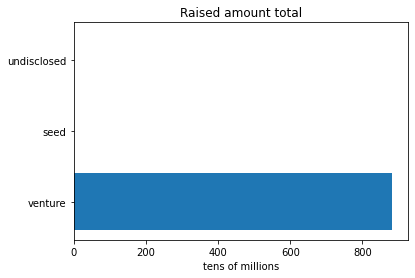

In [ ]:
plt.barh(dfGroupRounds_2.rdd.map(lambda x: x[0]).collect(), dfGroupRounds_2.rdd.map(lambda x: x[1]).collect())

plt.title("Raised amount total")
plt.xlabel("tens of millions")

Text(0.5, 0, 'tens of millions')

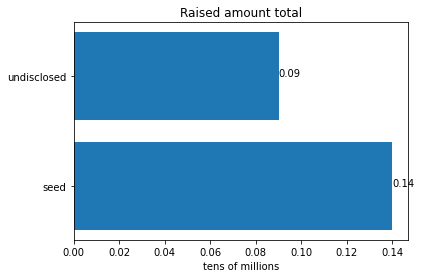

In [ ]:
#Debido a que la cantidad recaudada para la categoría venture es mucho mayor a
#la cantidad recaudada para las otras categorías, hacemos un análisis
#gráfico de las otras categorías excluyendo la categoría venture
values = dfGroupRounds_2.rdd.map(lambda x: x[1]).collect()[1:]
labels = dfGroupRounds_2.rdd.map(lambda x: x[0]).collect()[1:]
plt.barh(labels, values)

for i, value in enumerate(values):
  plt.text(value, i, str(value))

plt.title("Raised amount total")
plt.xlabel("tens of millions")